# Neural Networks

Neural Networks are graphs which consist of consecutive layers of nodes. They always begin with nodes which correspond to the input features. In a classification problem, the last layer will consist of one node per level of the response if we use the softmax activation function. If the response variable is binary, it is also possible to use the sigmoid with only one output node. This is what we will do here.

The nodes of a neural network's hidden layers are assigned biases, and its edges are assigned weights. These are the trainable parameters of the neural network. The activation function used between layers introduce nonlinearity in the model, which otherwise would consist only of linear combinations of the initial predictors.

## Sets imports and formatting

We begin by importing the necessary modules.

In [32]:
import pandas as pd
import numpy as np
import csv
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from livelossplot import PlotLossesKeras
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

We import the data and create `X` and `y` sets.

In [33]:
campaign_ad = pd.read_csv("MLUnige2023_subscriptions_train.csv", index_col="Id")
campaign_test = pd.read_csv("MLUnige2023_subscriptions_test.csv", index_col="Id")

X = campaign_ad.drop(columns='subscription')
y = campaign_ad['subscription']

# list of variables coded as strings
cat_vars_strings = ['job', 'marital', 'education', 'device', 'outcome_old']

We split the data into training, validation and test sets.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=46)

As we will see when building our neural network, it will require the input to be in a specific format which corresponds to its architecture. For this purpose, we create versions of `X_train`, `X_valid`, `X_test`, `X` and `campaign_test` which are suitable for our neural network.

In [35]:
X_train_input = [X_train['job'],
                 X_train['marital'],
                 X_train['education'],
                 X_train['device'],
                 X_train['outcome_old'],
                 X_train.drop(columns=cat_vars_strings)]

In [36]:
X_valid_input = [X_valid['job'],
                 X_valid['marital'],
                 X_valid['education'],
                 X_valid['device'],
                 X_valid['outcome_old'],
                 X_valid.drop(columns=cat_vars_strings)]

In [37]:
X_test_input =  [X_test['job'],
                 X_test['marital'],
                 X_test['education'],
                 X_test['device'],
                 X_test['outcome_old'],
                 X_test.drop(columns=cat_vars_strings)]

In [38]:
X_input = [X['job'],
           X['marital'],
           X['education'],
           X['device'],
           X['outcome_old'],
           X.drop(columns=cat_vars_strings)]

In [39]:
campaign_test_input = [campaign_test['job'],
                       campaign_test['marital'],
                       campaign_test['education'],
                       campaign_test['device'],
                       campaign_test['outcome_old'],
                       campaign_test.drop(columns=cat_vars_strings)]

## Grid Search

We will use the grid search to tune some hyperparameters of our model. However, we first build its architecture inside the following function.

The general idea is that each categorical feature which is coded as string inside our dataset will be preprocessed separately by the neural network. A `StringLookup` layer first translates the strings into integers, assigning a number to each different value of the categorical variable. It also defines an integer value which will stand for any string that is not one of the predefined levels of the variable. The `Embedding` layer takes as input the integer values and creates a vector for each. The output dimension allows to control of which length the vectors of each word will be.

For example, job has 12 levels (or words). `StringLookup` will assign them 13 integer values, from 0 to 12. Embedding will create a vector of length `output_dim` for each integer value. Each coordinate of the vectors will have its associated weight. In particular for job, which has the biggest number of levels, the value of the output dimension will be tuned using the grid search. This is a technique to reduce dimensions implicitely inside categorical variables which have multiple levels.

After the `Embedding` layer, in order to merge all the inputs together, the `Embedding` needs to be flattened using a `Flatten` layer.

Once all string categorical variables have gone through this process, a merging layer will combine all of these parallel inputs, together with the rest of the dataset features. Those features will have been scaled using a Normalization layer.

After the merge, we have a regular multilayer perceptron with layers slowly decreasing in node size until the output.

In [40]:
def build_model(hp):
    # Setting random seed for the initalization of the whole model
    keras.utils.set_random_seed(493)

    # JOB INPUT
    n_levels_job = len(X['job'].unique())
    input_job       = layers.Input(name='input_job', shape=(1,), dtype='string')
    str_to_ints_job = layers.StringLookup(name='str_to_ints_job', vocabulary=X['job'].unique())(input_job)
    embed_vecs_job  = layers.Embedding(name='embed_vecs_job',
                                    input_dim=n_levels_job + 1,
                                    output_dim=hp.get('output_job'))(str_to_ints_job)
    flat_job        = layers.Flatten(name='flat_job')(embed_vecs_job)

    # MARITAL INPUT
    n_levels_marital = len(X['marital'].unique())
    input_marital       = layers.Input(name='input_marital', shape=(1,), dtype='string')
    str_to_ints_marital = layers.StringLookup(name='str_to_ints_marital', vocabulary=X['marital'].unique())(input_marital)
    embed_vecs_marital  = layers.Embedding(name='embed_vecs_marital',
                                        input_dim=n_levels_marital + 1,
                                        output_dim=n_levels_marital)(str_to_ints_marital)
    flat_marital        = layers.Flatten(name='flat_marital')(embed_vecs_marital)

    # EDUCATION INPUT
    n_levels_education = len(X['education'].unique())
    input_education       = layers.Input(name='input_education', shape=(1,), dtype='string')
    str_to_ints_education = layers.StringLookup(name='str_to_ints_education', vocabulary=X['education'].unique())(input_education)
    embed_vecs_education  = layers.Embedding(name='embed_vecs_education',
                                            input_dim=n_levels_education + 1,
                                            output_dim=n_levels_education)(str_to_ints_education)
    flat_education        = layers.Flatten(name='flat_education')(embed_vecs_education)

    # DEVICE INPUT
    n_levels_device = len(X['device'].unique())
    input_device       = layers.Input(name='input_device', shape=(1,), dtype='string')
    str_to_ints_device = layers.StringLookup(name='str_to_ints_device', vocabulary=X['device'].unique())(input_device)
    embed_vecs_device  = layers.Embedding(name='embed_vecs_device',
                                        input_dim=n_levels_device + 1,
                                        output_dim=2)(str_to_ints_device)
    flat_device        = layers.Flatten(name='flat_device')(embed_vecs_device)

    # OUTCOME_OLD INPUT
    n_levels_outcome_old = len(X['outcome_old'].unique())
    input_outcome_old       = layers.Input(name='input_outcome_old', shape=(1,), dtype='string')
    str_to_ints_outcome_old = layers.StringLookup(name='str_to_ints_outcome_old', vocabulary=X['outcome_old'].unique())(input_outcome_old)
    embed_vecs_outcome_old  = layers.Embedding(name='embed_vecs_outcome_old',
                                            input_dim=n_levels_outcome_old + 1,
                                            output_dim=2)(str_to_ints_outcome_old)
    flat_outcome_old        = layers.Flatten(name='flat_outcome_old')(embed_vecs_outcome_old)

    # NUMERIC INPUTS
    num_inputs = layers.Input(name='num_inputs', shape=(11,))
    num_norm = layers.Normalization(name='num_norm', axis=1)(num_inputs)

    # MERGING INPUTS
    merged = layers.concatenate([flat_job,
                                flat_marital,
                                flat_education,
                                flat_device,
                                flat_outcome_old,
                                num_norm],
                                name='merged')

    # DENSE LAYERS
    dense1 = layers.Dense(name='dense1', units=hp.get('dense1_nodes'), activation='relu')(merged)
    dense2 = layers.Dense(name='dense2', units=16, activation='relu')(dense1)
    dense3 = layers.Dense(name='dense3', units=8, activation='relu')(dense2)
    dense4 = layers.Dense(name='dense4', units=4, activation='relu')(dense3)
    output = layers.Dense(name='output', units=1, activation='sigmoid')(dense4)

    # MODEL
    model = keras.Model(inputs=[input_job, input_marital, input_education, input_device, input_outcome_old, num_inputs],
                        outputs=[output])
    
    model.compile(loss = 'binary_crossentropy',
                  optimizer = keras.optimizers.Adam(learning_rate=hp.get('learning_rate')),
                  metrics= ['accuracy'])
    
    return model

The model has been defined above, and we have incorporated three hyperparameters that we will tune:
- The length of the output vectors for job
- The number of nodes in the first dense layer
- The learning rate of the optimizer

Their respective grid of values is defined below.

In [41]:
hp = HyperParameters()
hp.Choice('output_job', [12,9,6,3,1]);
hp.Choice('dense1_nodes', [64,32,16]);
hp.Choice('learning_rate', [0.0001, 0.001, 0.01, 0.1]);

To vizualise the structure of the model, we create a model example assigning values to the three tuning parameters we have defined above. This way, we can display its summary and its plot.

In [42]:
model_example = build_model(hp={'output_job': 12, 'dense1_nodes': 32, 'learning_rate': 0.001})

model_example.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_job (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 input_marital (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 input_education (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 input_device (InputLayer)      [(None, 1)]          0           []                               
                                                                                            

Of course, the number of parameters will change as we do our grid search. We notice that the 23 non-trainable parameters come from the `Normalization` layer, they are the mean and standard deviation of the variables which have been standardized.

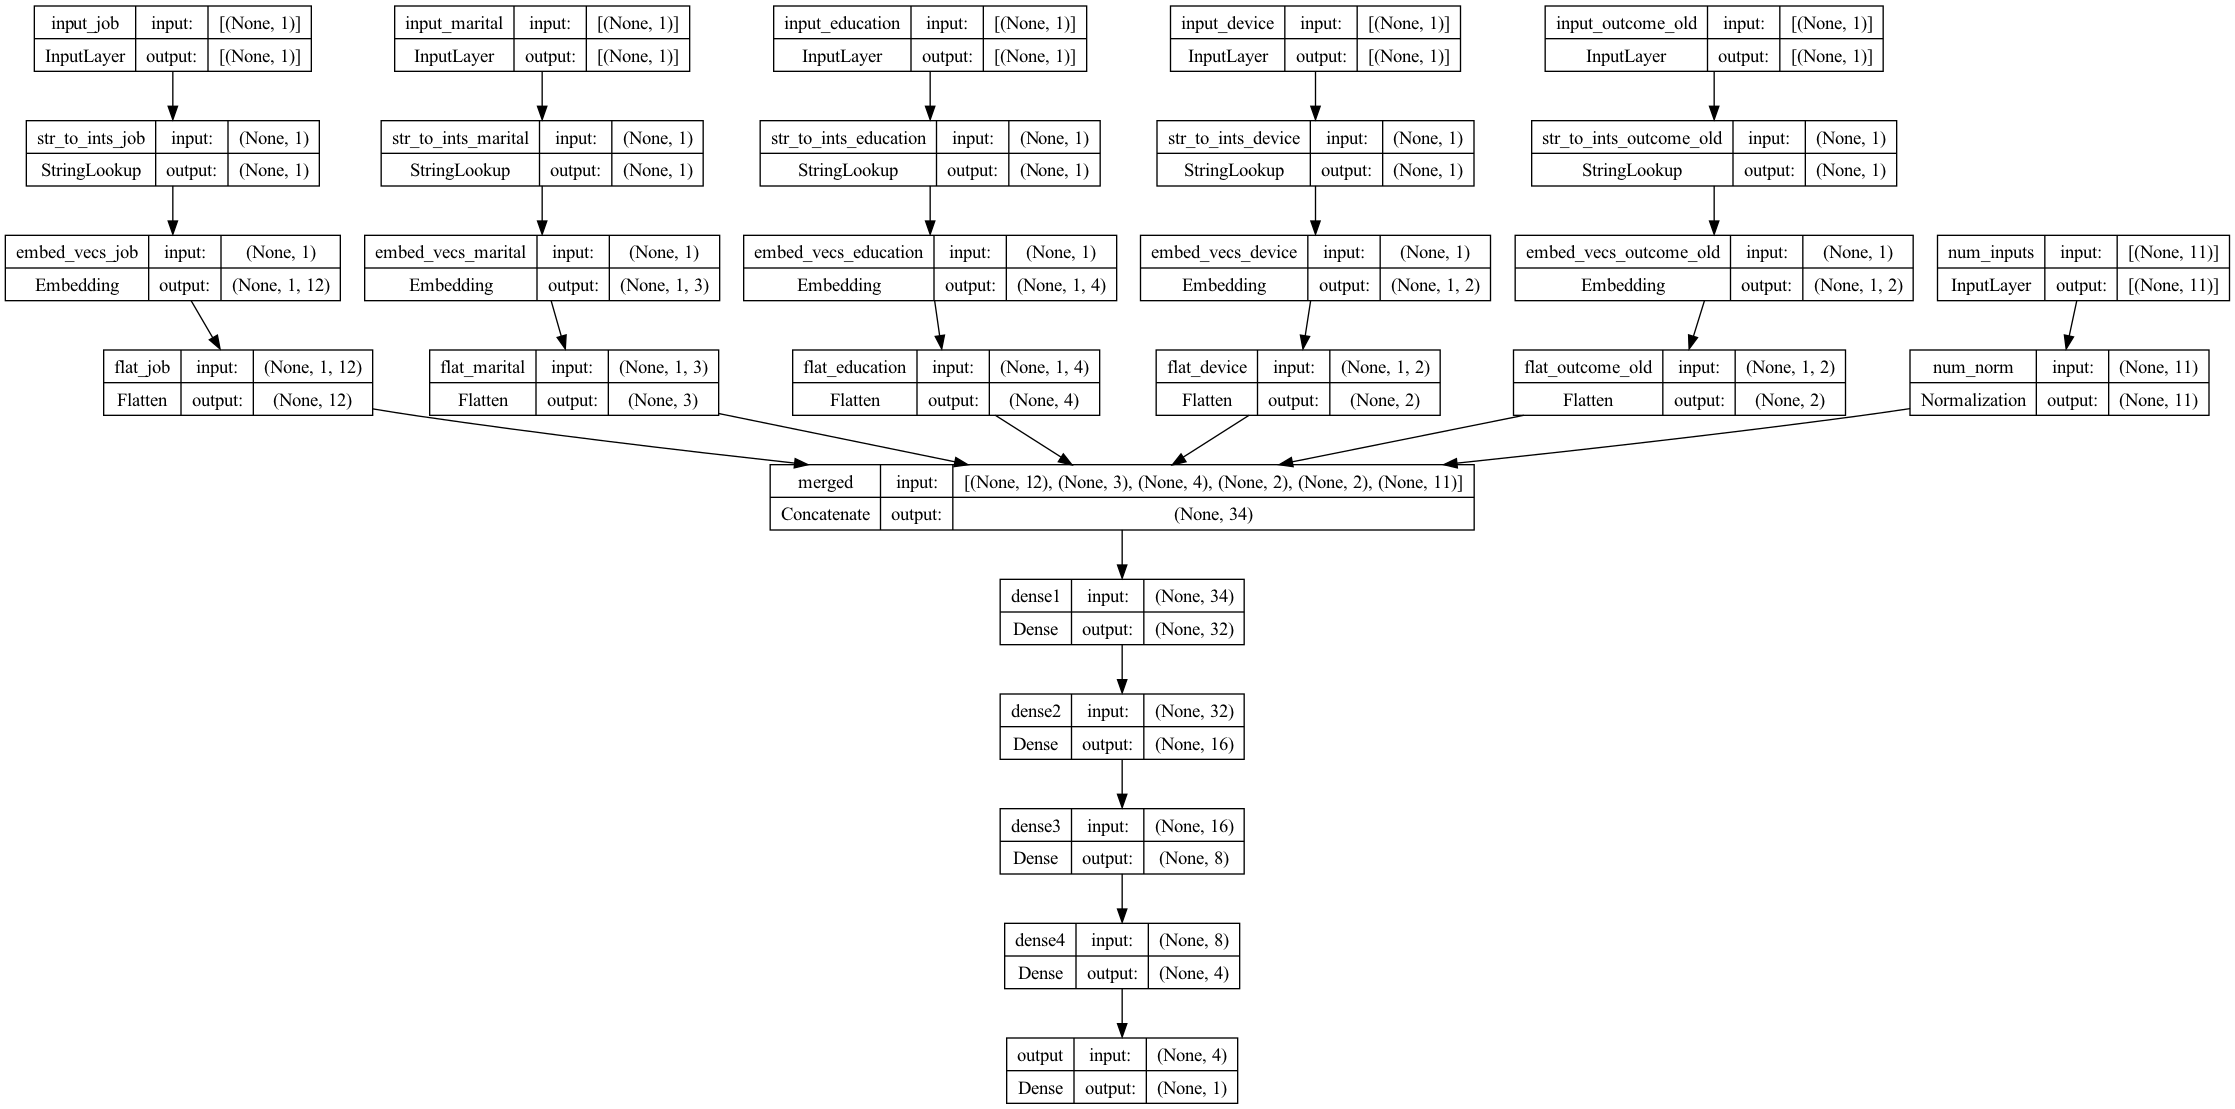

In [43]:
keras.utils.plot_model(model_example, show_shapes=True)

The architecture of the neural network is much more clearer once plotted. We see the different categorical inputs and the numerical ones which are all merged together, and the following dense layers.

Now, we can build the `RandomSearch` object. The `max_trials` parameter controls the number of different model configurations which are tried out. We set the `objective` to be the accuracy of the validation set.

In [44]:
tuner = RandomSearch(hypermodel = build_model,
                     hyperparameters=hp,
                     max_trials=60, 
                     objective="val_accuracy", 
                     allow_new_entries=False)

We are now ready to proceed with the grid search. After different having tried out 32, 64, and 128 as `batch_size`, a size of 64 seems to give better results. The number of epochs is set to 100, but we also implement early stopping which prevents us from continuing training a model which shows no significative improvement. The `PlotLossesKeras` function allows to have live evolving plots of the accuracy and the loss function as models are tried out.

In [45]:
tuner.search(x=X_train_input, y=y_train,
             validation_data=(X_valid_input, y_valid),
             batch_size=64,
             epochs=100,
             shuffle=True,
             callbacks=[PlotLossesKeras(), keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)])

Trial 58 Complete [00h 00m 24s]
val_accuracy: 0.8227847814559937

Best val_accuracy So Far: 0.8294862508773804
Total elapsed time: 00h 54m 20s
INFO:tensorflow:Oracle triggered exit


We can display a summary of the 10 best models found during the grid search.

In [46]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
output_job: 3
dense1_nodes: 64
learning_rate: 0.01
Score: 0.8294862508773804

Trial 30 summary
Hyperparameters:
output_job: 12
dense1_nodes: 64
learning_rate: 0.01
Score: 0.8265078067779541

Trial 26 summary
Hyperparameters:
output_job: 6
dense1_nodes: 16
learning_rate: 0.0001
Score: 0.8257632255554199

Trial 19 summary
Hyperparameters:
output_job: 6
dense1_nodes: 32
learning_rate: 0.001
Score: 0.8250186443328857

Trial 23 summary
Hyperparameters:
output_job: 6
dense1_nodes: 64
learning_rate: 0.001
Score: 0.8242740035057068

Trial 47 summary
Hyperparameters:
output_job: 3
dense1_nodes: 64
learning_rate: 0.0001
Score: 0.8242740035057068

Trial 41 summary
Hyperparameters:
output_job: 6
dense1_nodes: 32
learning_rate: 0.01
Score: 0.8235294222831726

Trial 27 summary
Hyperparameters:
output_job: 12
dense1_nodes: 16
learning_rate: 0.01
Score

We can also directly retrieve the best performing model and store it.

In [47]:
best_model = tuner.get_best_models(num_models=1)[0]

We store the best model's parameters and display them.

In [48]:
best_params = tuner.get_best_hyperparameters(num_trials=1)[0]

print('Vector length of job embedding:', best_params.get('output_job'))
print('Nodes of dense1 layer:',          best_params.get('dense1_nodes'))
print('Learning rate of the model:',     best_params.get('learning_rate'))

Vector length of job embedding: 3
Nodes of dense1 layer: 64
Learning rate of the model: 0.01


The length of vectors coming out of job is 3, which is quite small. This acts like an implicit reduction in the levels of job. The first dense layer is the biggest option we had given to the grid search.

We can compute the loss and accuracy of the model on the test set.

In [49]:
loss, accuracy = best_model.evaluate(X_test_input, y_test)

42/42 [==============================] - 0s 2ms/step - loss: 0.3902 - accuracy: 0.8369


The accuracy at 83% isn't too bad, but other models perform better.

We can display the summary and the plot of our best model.

In [50]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_job (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 input_marital (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 input_education (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 input_device (InputLayer)      [(None, 1)]          0           []                               
                                                                                              

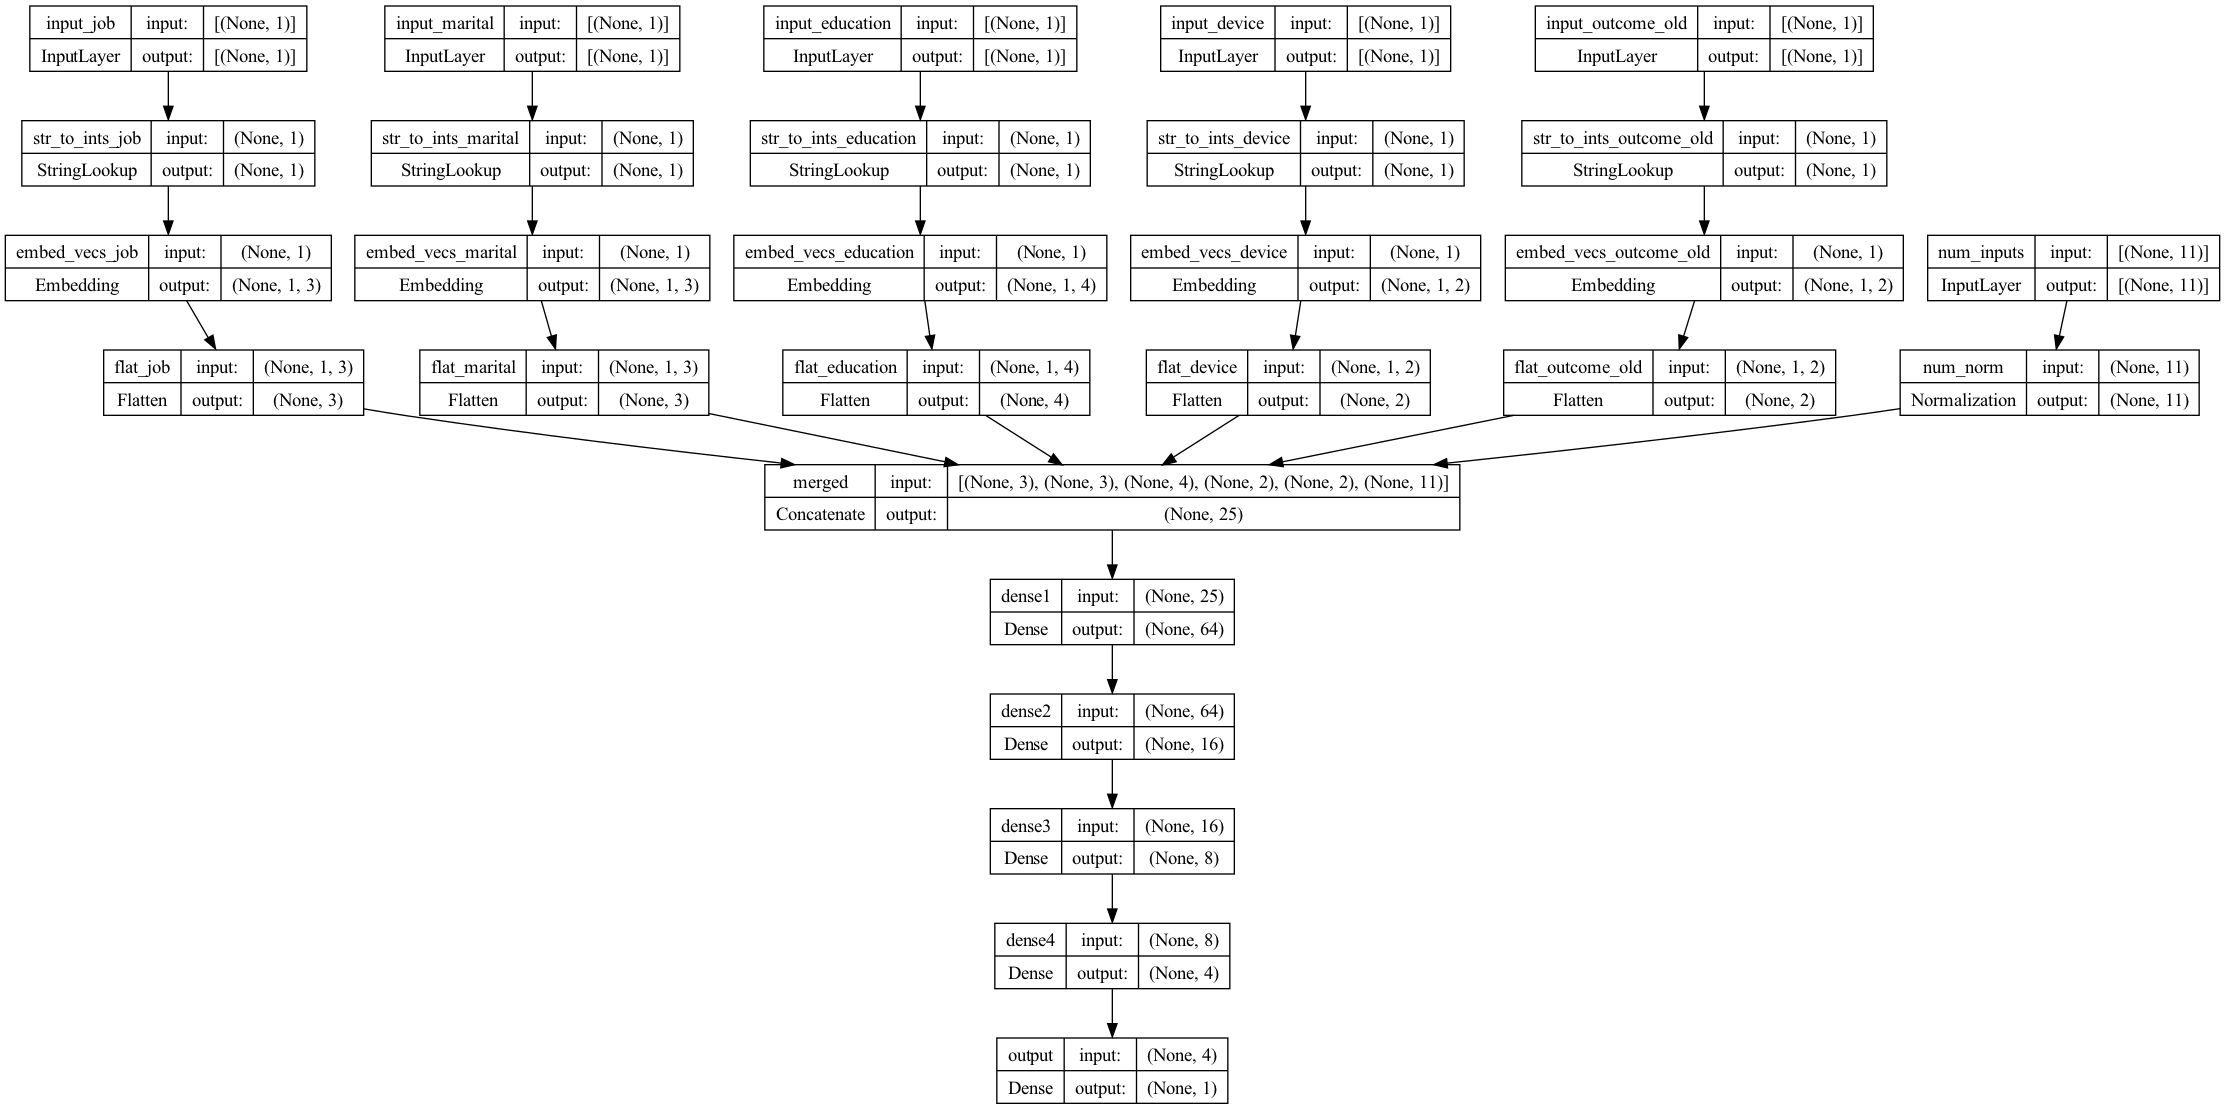

In [51]:
keras.utils.plot_model(best_model, show_shapes=True)

We rebuild a non-trained version of our best model.

In [62]:
best_model = build_model(hp={'output_job': 3, 'dense1_nodes': 64, 'learning_rate': 0.01})

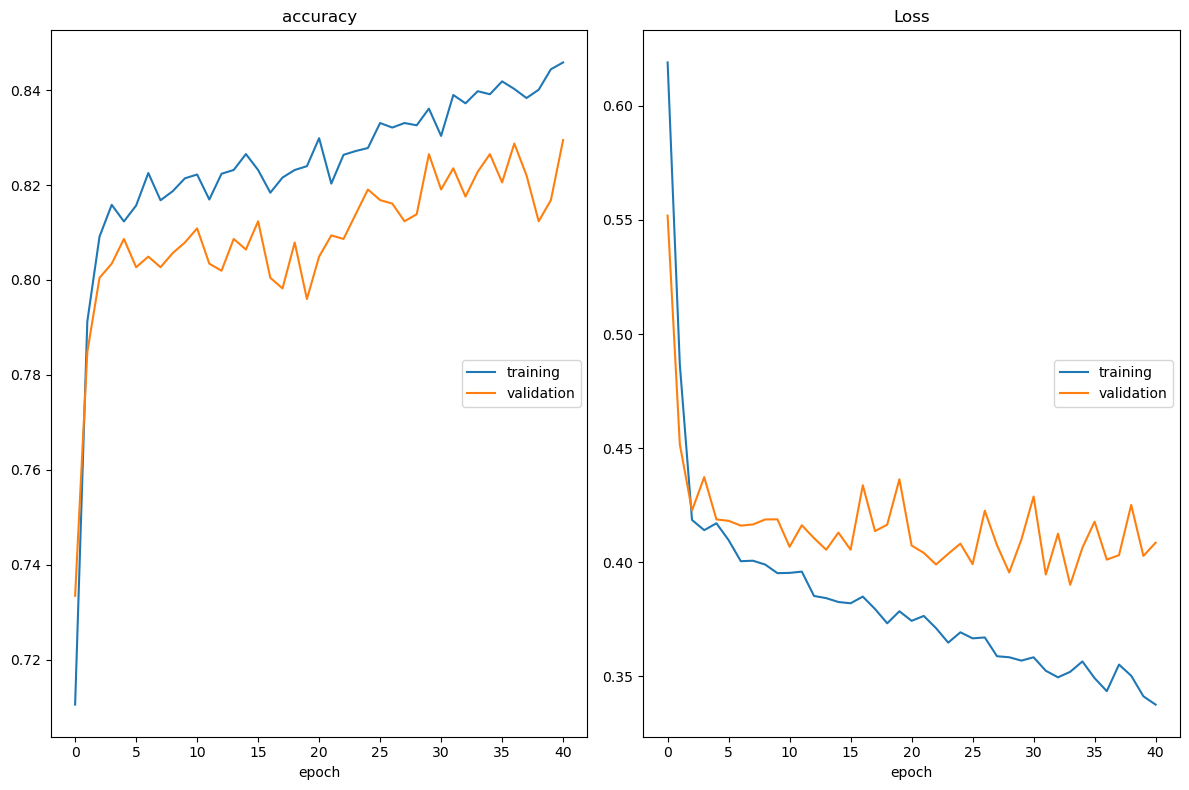

accuracy
	training         	 (min:    0.711, max:    0.846, cur:    0.846)
	validation       	 (min:    0.733, max:    0.829, cur:    0.829)
Loss
	training         	 (min:    0.338, max:    0.619, cur:    0.338)
	validation       	 (min:    0.390, max:    0.552, cur:    0.409)
98/98 [==============================] - 1s 12ms/step - loss: 0.3377 - accuracy: 0.8458 - val_loss: 0.4086 - val_accuracy: 0.8295


In [63]:
fit_history = best_model.fit(
    x=X_train_input, y=y_train, 
    validation_data=(X_valid_input, y_valid),
    batch_size=64,
    epochs=100,
    shuffle=True,
    callbacks=[PlotLossesKeras(), keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)])

We evaluate the accuracy and loss on the training, validation and test datasets.

In [64]:
best_model.evaluate(X_train_input, y_train)

196/196 [==============================] - 1s 3ms/step - loss: 0.3238 - accuracy: 0.8540


[0.3238137364387512, 0.8539738059043884]

In [65]:
best_model.evaluate(X_valid_input, y_valid)

42/42 [==============================] - 0s 3ms/step - loss: 0.4086 - accuracy: 0.8295


[0.4086116850376129, 0.8294862508773804]

In [66]:
best_model.evaluate(X_test_input, y_test)

42/42 [==============================] - 0s 4ms/step - loss: 0.3902 - accuracy: 0.8369


[0.39016297459602356, 0.8369322419166565]

We also evaluate the loss and accuracy on `campaign_ad` as a whole.

In [67]:
best_model.evaluate(X_input, y)

280/280 [==============================] - 1s 3ms/step - loss: 0.3465 - accuracy: 0.8477


[0.3464893400669098, 0.8477435111999512]

# Fit on whole `campaign_ad` and prediction on `campaign_test`

We now fit the model on the whole `campaign_ad` dataset.

In [68]:
best_model = build_model(hp={'output_job': 3, 'dense1_nodes': 64, 'learning_rate': 0.01})

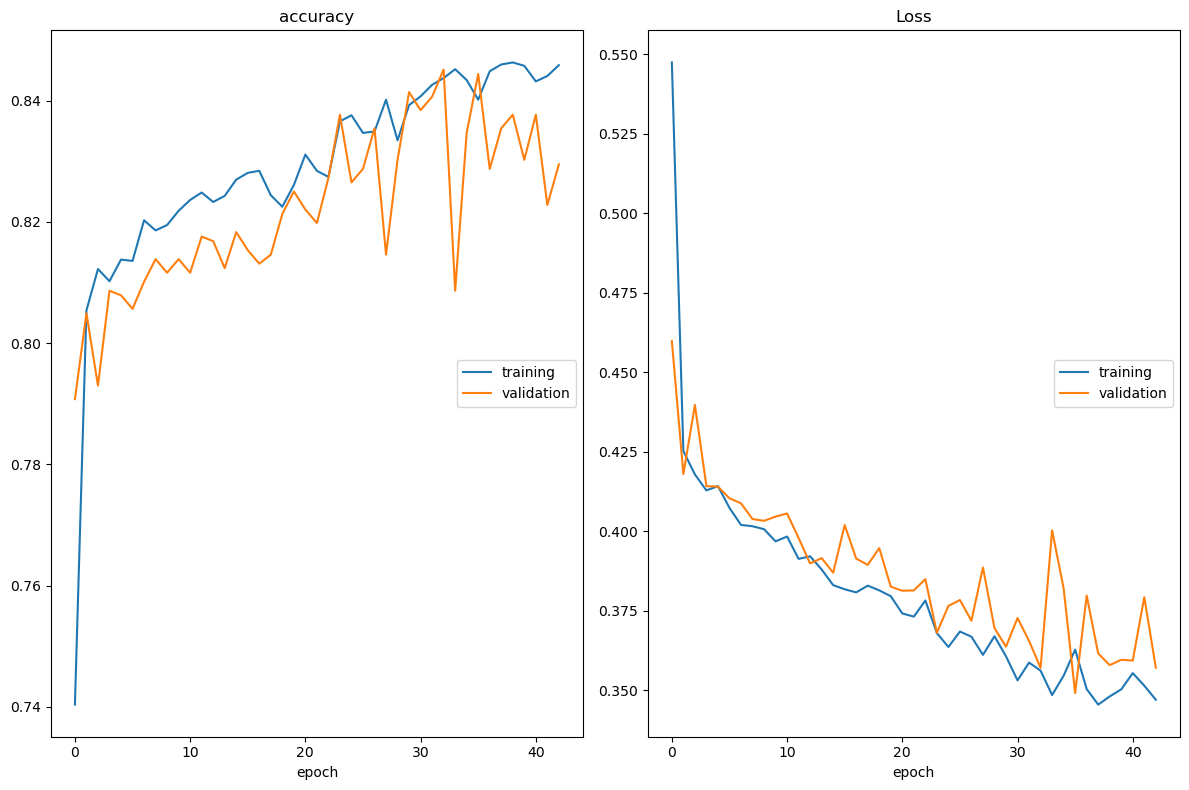

accuracy
	training         	 (min:    0.740, max:    0.846, cur:    0.846)
	validation       	 (min:    0.791, max:    0.845, cur:    0.829)
Loss
	training         	 (min:    0.346, max:    0.547, cur:    0.347)
	validation       	 (min:    0.349, max:    0.460, cur:    0.357)
140/140 [==============================] - 1s 10ms/step - loss: 0.3471 - accuracy: 0.8458 - val_loss: 0.3572 - val_accuracy: 0.8295


In [69]:
fit_history = best_model.fit(x=X_input, y=y, 
                   validation_data=(X_valid_input, y_valid),
                   batch_size=64,
                   epochs=100,
                   callbacks=[PlotLossesKeras(), keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)])

We can evaluate it on `campaign_ad`.

In [70]:
best_model.evaluate(X_input, y)

280/280 [==============================] - 1s 2ms/step - loss: 0.3403 - accuracy: 0.8471


[0.3403211534023285, 0.8470732569694519]

We now produce predictions for `campaign_test`. The `predict` method gives back probabilities, which need to be rounded.

In [76]:
y_REAL_test = np.round(best_model.predict(campaign_test_input)).astype(int)
y_REAL_test = y_REAL_test.ravel()
y_REAL_test

120/120 [==============================] - 1s 4ms/step


array([0, 1, 0, ..., 0, 1, 1])

Finally, we write a csv file to be uploaded to kaggle.

In [77]:
file = open('test_file_neuralnets.csv', 'w')
writer = csv.writer(file)
writer.writerow(['Id', 'subscription'])
for i in range(len(y_REAL_test)):
    writer.writerow([i, y_REAL_test[i]])
file.close()